In [63]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy
import random
import itertools
import matplotlib.patches as mpatches
from statistics import mean
from math import e
import operator
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import modularity
from networkx.algorithms.community import naive_greedy_modularity_communities
from mlflow import log_metric, log_param, log_artifacts


### Useful functions

In [56]:
#Useful functions

    #loading data for Graph generation
def load_data(filename):
    input_lines = []
    raw_lines = open(filename, 'r').read().splitlines()
    num_nodes = 0
    nodes = {}
    for line in raw_lines:
        line_content = line.split()
        from_id = int(line_content[0])
        to_id = int(line_content[1])
        if from_id not in nodes:
            nodes[from_id] = num_nodes
            num_nodes += 1
        if to_id not in nodes:
            nodes[to_id] = num_nodes
            num_nodes += 1
        input_lines.append([nodes[from_id], nodes[to_id]])
    return input_lines, num_nodes

#Display statistic of nodes degree
def show_degree_distribution(G,name):
    nodes_degrees_x = []
    nodes_degrees_y = []
    G2 = G.copy()
    edges_counter = 1
    generation = 0
    while True:
        iter_counter = 0
        for e in G2.nodes:
            if len(list(G2.neighbors(e))) == edges_counter:
                iter_counter += 1
        if iter_counter == 0 : break
        nodes_degrees_x.append(generation)
        nodes_degrees_y.append(iter_counter)
        generation +=1
        edges_counter += 1

    fig = plt.figure(1, figsize=(20, 20))
    ax = fig.add_subplot(211)
    ax.scatter(nodes_degrees_x,nodes_degrees_y,s=50,facecolor='none',edgecolors='r')
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.ylabel("No. node",fontsize=18)
    plt.xlabel("Degree",fontsize=18)
    red_patch = mpatches.Patch(color="red", label=name)
    ax.legend(handles=[red_patch],prop={'size': 20})
    plt.show()

def filtered_graph(G):
    node_list = []
    for e in G.nodes:
        neigh_list = list(G.neighbors(e))
        if  len(neigh_list) == 1:
            neigh = neigh_list[0]
            node_list.append([e,neigh])
    if len(node_list) != 0:
        for n in node_list:
            if(G.has_edge(n[0],n[1])):
                G.remove_edge(n[0],n[1])
            # Gb_copy.remove_node(n[0])
        return filtered_graph(G)
    return G

def get_subgraphs_cluster(G):
    communities = greedy_modularity_communities(G)
    print("Number of communities with best modularity: "+str(len(communities)))
    communities_subgraphs = []
    for c in communities:
        communities_subgraphs.append(G.subgraph(c))
    return communities_subgraphs

def compute_distance_v_Ci(v,cluster,G_biconnected_core,sigma):
    links_Ci_Ci = cluster.number_of_edges() #number of intra-cluster links
    deg_Ci = sum(dict(G_biconnected_core.degree(cluster.nodes())).values())
    deg_V = G_biconnected_core.degree(v)
    links_v_Ci = cluster.degree(v)
    distance = -1*((2*links_v_Ci) /(deg_V*deg_Ci)) + links_Ci_Ci/(deg_Ci**2) + (sigma/deg_V) - (sigma/deg_Ci)
    return distance

def compute_graclus_center(clusters_list,G_biconnected_core):
    seed_dict = {}
    for (idx,cluster) in enumerate(clusters_list):
        distance_array = {}
        for n in cluster.nodes:
            distance = compute_distance_v_Ci(n,cluster,G_biconnected_core,1)
            distance_array[n] = distance
        seed_dict["C"+str(idx)] = min([(value,key) for key,value in distance_array.items()])[1]
    return seed_dict
    
def compute_seed_by_spred_hubs(G,k):
    seed_list  = []
    while len(seed_list) < k:
        filtered_visited = [n for n in G.nodes() if G.nodes[n]["visited"] == False]
        filtered_visited_graph = G.subgraph(filtered_visited)
        max_degree = max([e[1] for e in filtered_visited_graph.degree])
        filtered_nodes = [n for n in G.nodes() if G.degree(n) == max_degree] 
        for n in filtered_nodes:
            seed_list.append(n)
            G.nodes[n]["visited"] = True
            for neig in G.neighbors(n):
                G.nodes[neig]["visited"] = True
    return 

class ConductanceStatistic:
    def __init__(self,g1_nodes,g2_nodes,conductance_value):
        self.g1_nodes = g1_nodes
        self.g2_nodes = g2_nodes
        self.conductance_value = conductance_value
    
    


## Loading and decsription data Phase

In [57]:
#Load dataset into networkx
dataset_name="Facebook"
# path ="..\datasets\\toy\\toy.txt"
# path ="..\datasets\\email\\email_Eu_core.txt"
# path ="..\datasets\\facebook\\0.edges"
path ="..\datasets\\network_100\\network_1000_7327.lfi"
# path ="..\datasets\\facebook\\3980.edges"
# path ="..\datasets\\myspace\\soc-myspace.edges"
# path ="..\datasets\\HepPh\\ca-HepPh.mtx"
# path = "..\datasets\\AstroPh\\AstroPh.txt"

input_edges, num_nodes = load_data(path)
# G = nx.Graph(input_edges)
G = nx.read_edgelist(path,create_using=nx.Graph(), nodetype = int)
for n in G.nodes:
    G.nodes[n]["visited"] = False

print(G.nodes)


# fig = plt.figure(1, figsize=(20, 20), dpi=80)
# nx.draw(G, node_size=100,with_labels=True)

[0, 549, 645, 787, 847, 958, 974, 990, 1, 192, 307, 442, 603, 693, 903, 2, 612, 662, 793, 888, 994, 3, 216, 587, 773, 893, 928, 959, 976, 4, 151, 315, 382, 714, 836, 908, 919, 5, 188, 341, 409, 556, 580, 669, 845, 6, 408, 582, 724, 830, 840, 861, 7, 458, 561, 634, 682, 733, 799, 900, 8, 116, 277, 680, 692, 819, 983, 9, 159, 181, 863, 865, 937, 967, 10, 387, 463, 758, 763, 867, 883, 11, 638, 811, 854, 862, 887, 918, 12, 284, 605, 709, 925, 952, 970, 13, 56, 132, 471, 869, 871, 935, 954, 14, 228, 347, 557, 822, 912, 922, 15, 96, 122, 170, 329, 533, 798, 16, 667, 677, 710, 734, 735, 808, 979, 17, 208, 281, 518, 578, 781, 915, 18, 369, 411, 469, 486, 930, 991, 19, 49, 317, 385, 462, 595, 630, 20, 422, 740, 849, 860, 868, 961, 21, 207, 318, 573, 899, 953, 22, 100, 301, 337, 346, 546, 823, 841, 23, 711, 757, 807, 941, 980, 984, 24, 621, 690, 761, 911, 936, 985, 25, 253, 403, 727, 780, 987, 26, 542, 741, 800, 842, 901, 981, 27, 84, 504, 538, 905, 993, 996, 28, 205, 552, 620, 880, 977, 997, 99

In [58]:
#Dataset descritpion
max_degree = max([e[1] for e in G.degree])
avg_degree = '{0:.3g}'.format(mean([e[1] for e in G.degree]))
avg_clustering_coefficient = '{0:.4g}'.format(nx.average_clustering(G))

dt_description = pd.DataFrame({
    "name":[dataset_name],
    "No. vertices":[G.number_of_nodes()],
    "No. edges":[G.number_of_edges()],
    "Max. deg":[max_degree],
    "Avg. deg":[avg_degree],
    "Avg. CC":[avg_clustering_coefficient]})
print(dt_description)

#Graph for show degree distribution of nodes
#show_degree_distribution(G,dataset_name)

       name  No. vertices  No. edges  Max. deg Avg. deg Avg. CC
0  Facebook          1000       7327        50     14.7  0.2159


## Filtering Phase

In this phase firt we filter the graph, we start removing the whiskers which are nodes connected only with one bridge.

We repeat the operation until no more nodes have ony one connection, the resulted graph is called biconnected core.

The biconnected core is defined as the largest connected component of the graph after we remove all single-edge biconnected components (whiskers).

In [59]:
#Filtering phase
    #Filtering the graph, removing the  whiskers from the biconnected core
def filter_detached_graph(G,G_biconnected_core):
    for n in G_biconnected_core.nodes:
        G.remove_node(n)
    return G


G2 = G.copy()
G3 = filtered_graph(G2)



G_biconnected_core = G3.subgraph(max(nx.connected_components(G3), key=len)).copy()

# fig = plt.figure(1, figsize=(20, 20), dpi=80)
# nx.draw(G_biconnected_core , node_size=50,with_labels=True)
# plt.show()

G_detached = filter_detached_graph(G.copy(),G_biconnected_core)
print(G_detached)

# fig = plt.figure(1, figsize=(20, 20), dpi=80)
# nx.draw(G_detached , node_size=50,with_labels=True)
# plt.show()

print("G statistics before filtering:")
print("     -"+nx.info(G))
print("G_biconnected statistics after filtering:")
print("     -"+nx.info(G_biconnected_core))
print("")
perc_no_verticles = '{0:.3g}'.format(len(G_biconnected_core.nodes)/len(G.nodes)*100)
perc_no_edges = '{0:.3g}'.format(len(G_biconnected_core.edges)/len(G.edges)*100)
max_comp_detach =  len(max(nx.connected_components(G_detached), key=len))
perc_max_comp_detach ='{0:.3g}'.format(max_comp_detach / len(G.nodes) * 100) 

bc_description = pd.DataFrame({
    "No. of vertices (%)":[str(len(G_biconnected_core.nodes))+'('+str(perc_no_verticles)+')'],
    "No. of edges (%)":[str(len(G_biconnected_core.edges))+'('+str(perc_no_edges)+')'],
    "No. components detached":[len(G_detached.nodes)],
    "Size of the LCC (%)":[str(max_comp_detach)+"("+str(perc_max_comp_detach)+")"]})
print(bc_description)




Graph with 0 nodes and 0 edges
G statistics before filtering:
     -Graph with 1000 nodes and 7327 edges
G_biconnected statistics after filtering:
     -Graph with 1000 nodes and 7327 edges



ValueError: max() arg is an empty sequence

## Seeding Phase

The goal of an effective seeding strategy is to identify a diversity of vertices, each of which lies

within a cluster of good conductance.

In [ ]:
# def get_best_partition(G):
#     modularity_list = []
#     counter = 0
#     print("starting girvan newmann community detection")
#     communities = girvan_newman(G)
#     len_community = len(list(communities))
#     print("finiseh community detection")
#     for c in communities:
#         print("Elaborating "+str(counter) +" of "+str(len_community))
#         modularity_list.append(modularity(G,c))
#         counter += 1

#     plt.plot(np.arange(len(modularity_list)),modularity_list)
#     plt.xlabel("Community level")
#     plt.ylabel("Modularity")
#     plt.show()
#     return
# G_partitioned = get_best_partition(G_biconnected_core)

In [60]:
#Exhaustive non-overlapping clusters on G_biconnected_core
communities_subgraphs_clusters = get_subgraphs_cluster(G_biconnected_core)
#Get seed list computing the Graclus center algorithm
seed_dict_gc = compute_graclus_center(communities_subgraphs_clusters,G_biconnected_core)
#Get seed list computing the Spread Hubs

Number of communities with best modularity: 8


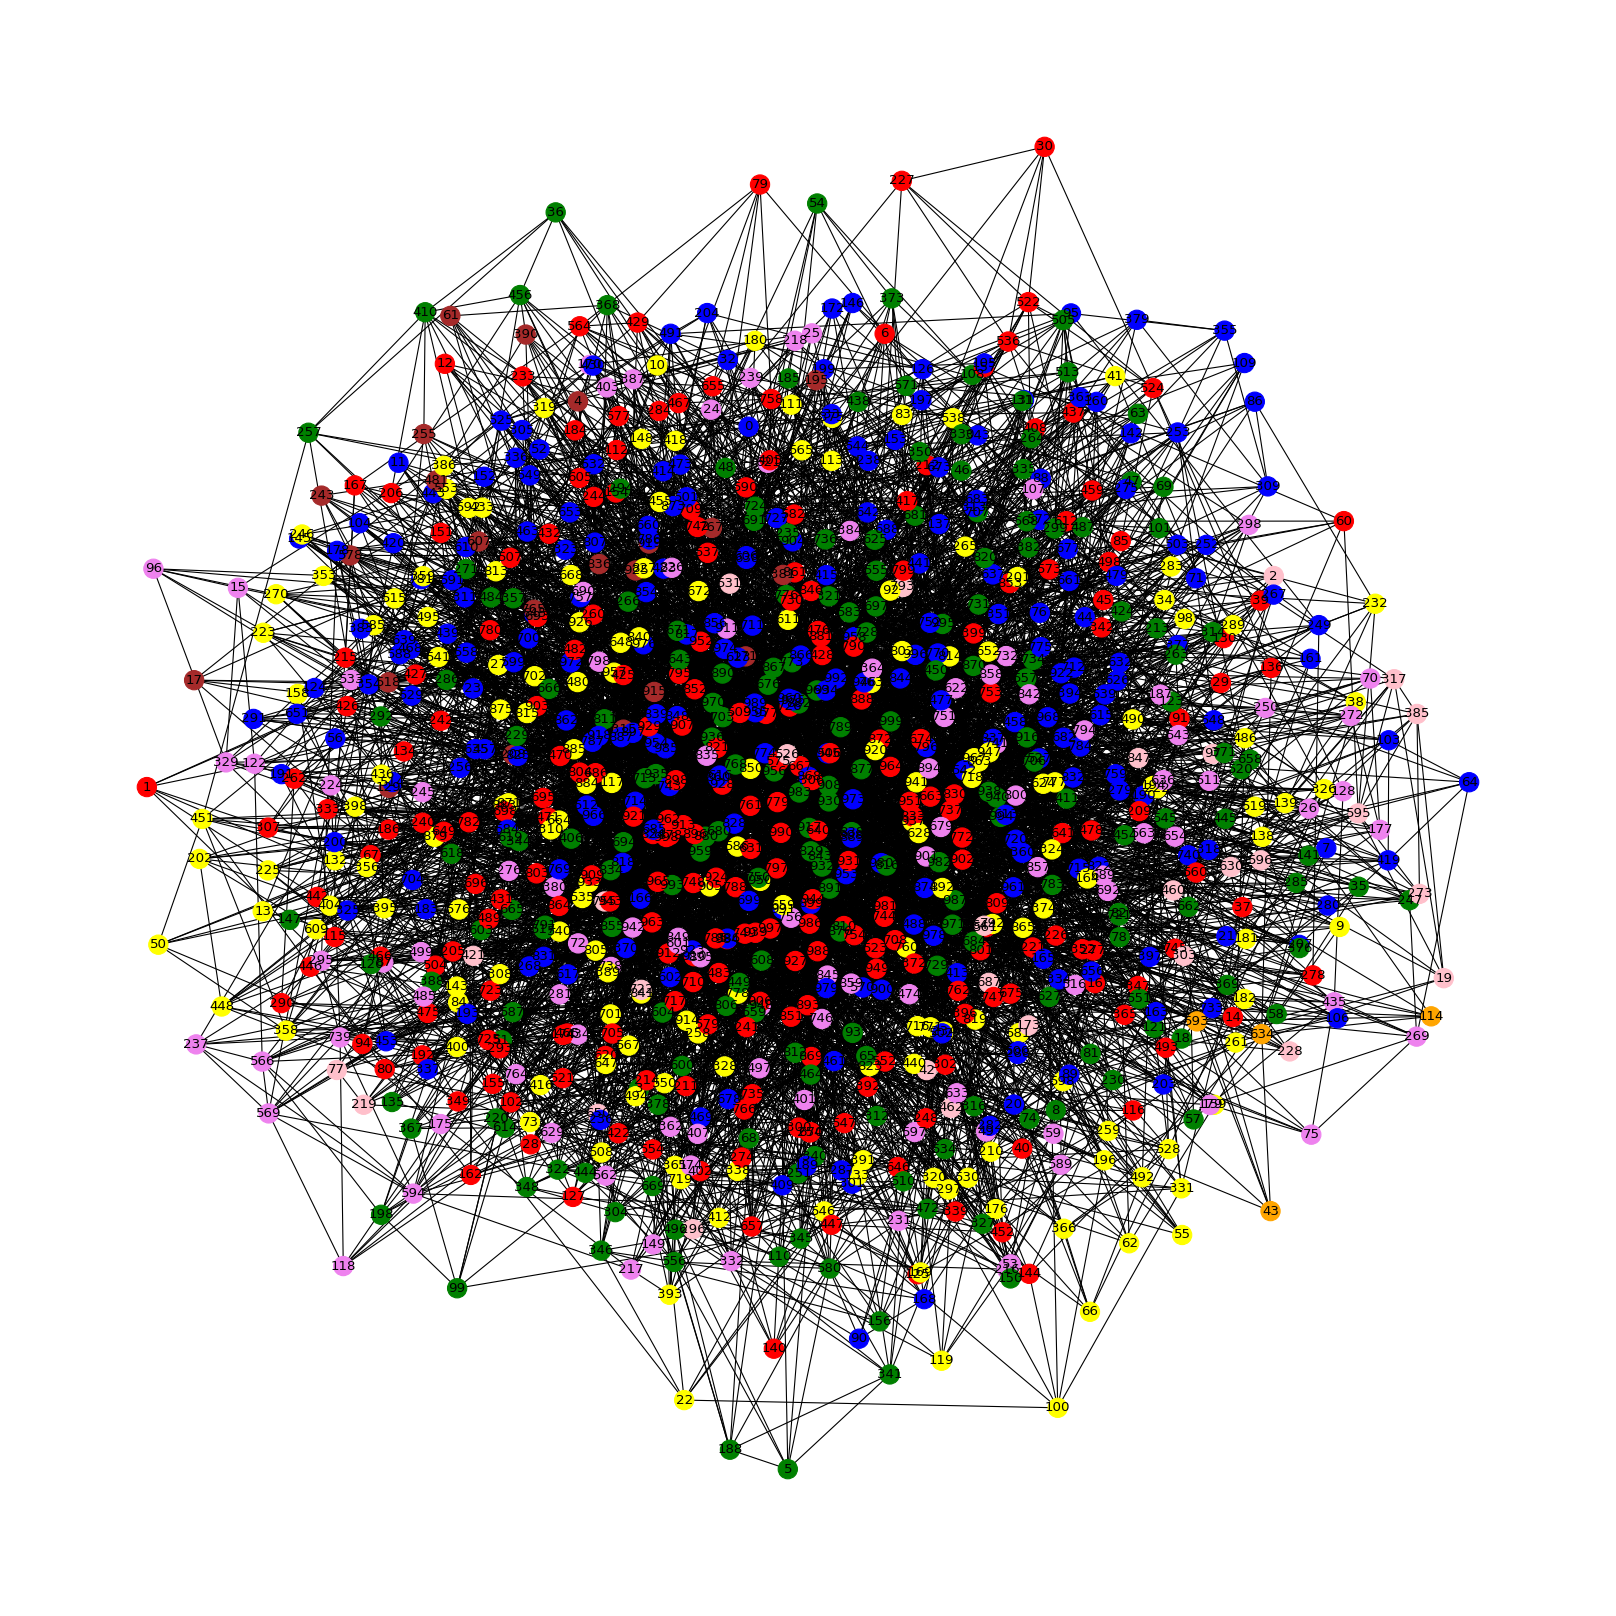

In [61]:
color_map = ['red']*len(G_biconnected_core.nodes)
color = ['red','blue','green','yellow','violet','pink','brown','orange']
count = 0
for el in communities_subgraphs_clusters:
    for node in el:
        idx = list(G_biconnected_core.nodes).index(int(node))
        color_map[idx] = color[count]
    count+=1
    
fig = plt.figure(1, figsize=(20, 20), dpi=80)
nx.draw(G_biconnected_core, node_color=color_map, with_labels=True)

## Seed expansion phase

C0 998


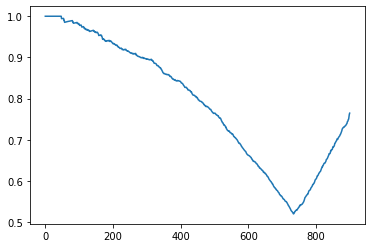

999
0.5196613872200984
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,

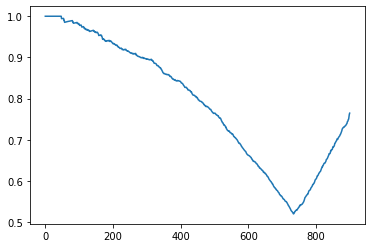

999
0.5196613872200984
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,

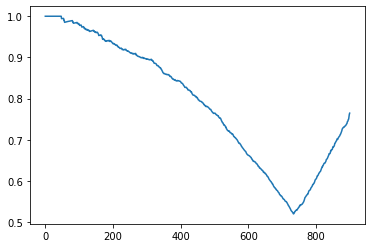

999
0.5196613872200984
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,

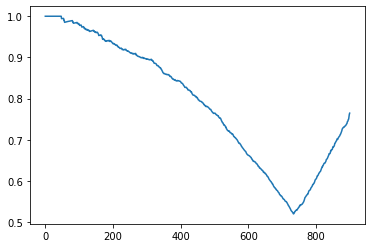

999
0.5196613872200984
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,

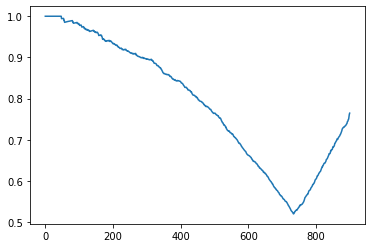

999
0.5196613872200984
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,

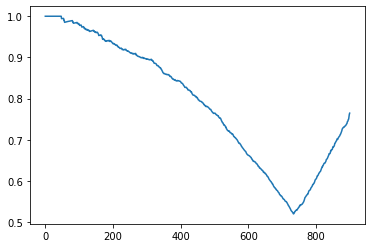

999
0.5196613872200984
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,

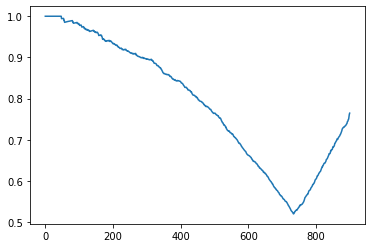

999
0.5196613872200984
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,

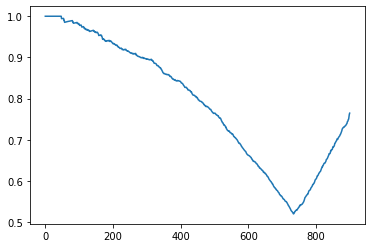

999
0.5196613872200984
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,

In [64]:
#new implementation
from sqlalchemy import false


k = 8
Gb_copy = G_biconnected_core.copy()
expanded_community_list = []

#seed phaseù
alpha = 0.9
epsilon = e**-8

for key,val in seed_dict_gc.items():
    print(key,val)
    #initialization
    restart_node =  list(Gb_copy.neighbors(val))+[val] 
    Xv = np.zeros(max(list(Gb_copy.nodes)))
    Rv = np.zeros(max(list(Gb_copy.nodes)))

    for el in restart_node:
        n_neighbors = len(list(Gb_copy.neighbors(el)))
        Rv[el-1] = 1 / len(restart_node)

    finish_count = 0
    count = 0
    isRunning = True

    #computation code
    while isRunning:
        node = list(Gb_copy.nodes)[count]
        if Rv[node-1] > len(list(Gb_copy.neighbors(node)))*epsilon:
            finish_count = 0
            Xv[node-1] = Xv[node-1] + (1-alpha)*Rv[node-1]
            for el in Gb_copy.neighbors(node):
                Rv[el-1] = Rv[el-1] + alpha*Rv[node-1]/(2*len(list(Gb_copy.neighbors(node))))
            Rv[node-1] = alpha*Rv[node-1]/2
            
        else:
            finish_count += 1

        if finish_count == len(list(Gb_copy.nodes)): break
        if count == len(list(Gb_copy.nodes))-1: count = 0
        count += 1
    
    #ordering by descending 
    descending_graph_ordering = {}
    for (idx,el) in enumerate(Xv):
        if(Gb_copy.has_node(idx + 1)):
            descending_graph_ordering[idx+1] = el / len(list(Gb_copy.neighbors(idx+1)))
            
    descending_graph_ordering = dict( sorted(descending_graph_ordering.items(), key=operator.itemgetter(1),reverse=True))
    # print(descending_graph_ordering)



    #Filter and get only 90% of total nodes
    maximun_nodes_iterations = int(len(descending_graph_ordering)*90/100)
    #calculate conductance
    current_set = []
    conductace_values = []
    conductance_list_set = []
    count_iteration = 0
    for (key,val) in descending_graph_ordering.items():
        if(count_iteration <= maximun_nodes_iterations):
            G2 = G_biconnected_core.copy()
            current_set.append(key) 
            conductance_value = nx.conductance(G2,current_set)
            conductace_values.append(conductance_value)

            G2.remove_nodes_from(current_set)
            cond = ConductanceStatistic(current_set, list(G2.nodes),conductance_value)
            conductance_list_set.append(cond)
            count_iteration += 1

    plt.plot(conductace_values)
    plt.show()

    #Calculate conductance min
    cond_min = ConductanceStatistic(0,0,1)
    for el in conductance_list_set:
        if(el.conductance_value < cond_min.conductance_value):
            cond_min = el
 

    #print
    print(key)
    print(cond_min.conductance_value)
    print(cond_min.g1_nodes)
    print(cond_min.g2_nodes)
    expanded_community_list.append(cond_min)

    # G_color = G.copy()
    # print()
    # color_map = ['blue']*len(G.nodes)
    # for node in cond_min.g2_nodes:
    #     idx = list(G_color.nodes).index(int(node))
    #     color_map[idx] = 'red'

    # fig = plt.figure(1, figsize=(20, 20), dpi=80)
    # nx.draw(G_color, node_color=color_map, with_labels=True)
    # plt.show()
    # print(filtered_nodes)
    # print(Gb_copy.degree(filtered_nodes))


## Seed expansion phase

In [ ]:
G_final = G.copy()
G_biconnected_copy = G_biconnected_core.copy()
G_detached_node_list = list(G_detached.nodes)

for c in expanded_community_list:
    print(len(c.g1_nodes))
    do_boundaries = True
    boundary_nodes = nx.node_boundary(G_final,c.g1_nodes)
    while do_boundaries:
        do_boundaries = False
        for node in G_detached_node_list:
            if node in boundary_nodes:
                do_boundaries = True
                c.g1_nodes.append(node)

    print(len(c.g1_nodes))
    print("--")








270


MemoryError: 

In [ ]:
expanded_community_list[0].g2_nodes

[236,
 175,
 46,
 23,
 116,
 275,
 273,
 28,
 312,
 214,
 20,
 71,
 333,
 78,
 144,
 226,
 149,
 17,
 326,
 140,
 137,
 343,
 115,
 111,
 14,
 310,
 32,
 278,
 230,
 174,
 293,
 2,
 263,
 162,
 19,
 218,
 243,
 195,
 181,
 8,
 245,
 328,
 99,
 296,
 102,
 306,
 177,
 259,
 167,
 227,
 91,
 143,
 61,
 93,
 41,
 6,
 89,
 337,
 110,
 264,
 225,
 86,
 152,
 201,
 289,
 321,
 68,
 131,
 262,
 220,
 44,
 193,
 97,
 112,
 151,
 4,
 327,
 95,
 319,
 155,
 147,
 219,
 182,
 253]